In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.cm import ScalarMappable
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize,rgb2hex
from matplotlib.patches import Polygon

%matplotlib inline

In [2]:
df = pd.read_csv('UCR65_16.csv')
df['State'] = df.State.apply(lambda x: x.replace('Rhodes','Rhode')) # fix a typo for basemap compatibility
df.head()

,ORI,Name,YEAR,MRD,CLR,State,County,Agency
0,AK00101,ANCHORAGE,1965,7,6,Alaska,"Anchorage, AK",Anchorage
1,AK00101,ANCHORAGE,1966,18,16,Alaska,"Anchorage, AK",Anchorage
2,AK00101,ANCHORAGE,1967,1,1,Alaska,"Anchorage, AK",Anchorage
3,AK00101,ANCHORAGE,1968,7,5,Alaska,"Anchorage, AK",Anchorage
4,AK00101,ANCHORAGE,1969,7,4,Alaska,"Anchorage, AK",Anchorage


In [3]:
# group and pivot the data for plotting
grp = df[['State','MRD','CLR']].groupby('State').sum()
grp['UnSolved Rate'] = 1 - (grp['CLR'] / grp['MRD'])
grp.sort_values(by='UnSolved Rate', ascending=False).head()

,MRD,CLR,UnSolved Rate
State,,,
Illinois,46345,17610,0.620024
Michigan,40978,22449,0.452169
Indiana,16430,9859,0.399939
New York,75873,45978,0.394014
Alabama,19117,11646,0.390804


In [4]:
# put the data into a dictionary for plotting
unsolved_rate_dict = grp['UnSolved Rate'].to_dict()

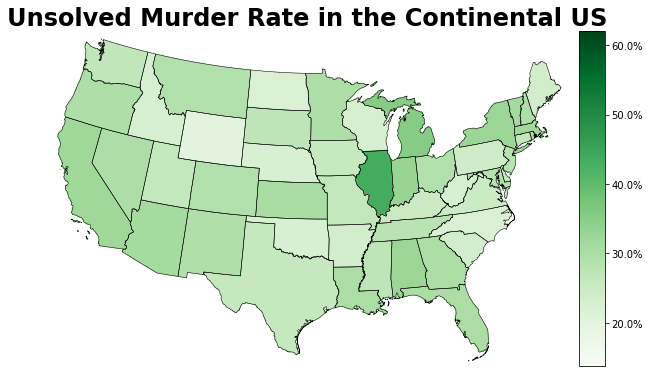

In [5]:
# https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states
# the above stackoverflow question made this chart possible
fig, ax = plt.subplots(figsize=(10,7))

for pos in ax.spines:
    ax.spines[pos].set_visible(False)

m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95,ax=ax)
shp_info = m.readshapefile('st99_d00','states',drawbounds=True)

colors={}
statenames=[]
cmap = plt.cm.Greens # use 'hot' colormap
vmin = grp['UnSolved Rate'].min(); vmax = grp['UnSolved Rate'].max() # set range.
norm = Normalize(vmin=vmin, vmax=vmax)
mapper = ScalarMappable(norm=norm, cmap=cmap)
for shapedict in m.states_info:
    statename = shapedict['NAME']
    # skip DC and Puerto Rico.
    if statename not in ['District of Columbia','Puerto Rico']:
#         rate = unsolved_dict[statename]
        rate = unsolved_rate_dict[statename]
        # calling colormap with value between 0 and 1 returns
        # rgba value.
        colors[statename] = cmap(rate)[:3]
#         colors[statename] = cmap((rate - vmin)/vmax)[:3]
#         colors[statename] = cmap(np.sqrt((rate-vmin)/vmax))[:3]

    statenames.append(statename)
# cycle through state names, color each one.
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] not in ['District of Columbia','Puerto Rico']:
        color = rgb2hex(colors[statenames[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)
mapper.set_array([])
cbar = m.colorbar(mapper,ax=ax,format=mpl.ticker.PercentFormatter(xmax=1))
ax.set_title('Unsolved Murder Rate in the Continental US',fontsize=24,fontweight='bold')
plt.show()